# Final Project: 1C Company - Predict Future Sales (Kaggle)
Target: Predict number of sales for based on shop_id and item_id for the next month (November 2015). Results are clipped to [0, 20]

Given: Data of the last 33 month.

Metric: RMSE

https://www.kaggle.com/c/competitive-data-science-final-project

#### Results: The best public / private score was achieved using lgbm after feature engineering and advanced feature engineering.

In [1]:
# show python version
!python --version

Python 3.9.2


In [6]:
# import python standard libraries
import os
import gc
import time
import pickle as pkl
import warnings
from itertools import product

# import other libraries
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction import text
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import NMF
import xgboost as xgb
from catboost import CatBoostRegressor

pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

# print package versions
import tqdm as tqdm_module
import sklearn
import matplotlib
for p in [np, pd, matplotlib, sns, lgb, tqdm_module, sklearn]:
    print('Name: {},      \tVersion: {}'.format(p.__name__, p.__version__))

Name: numpy,      	Version: 1.20.2
Name: pandas,      	Version: 1.2.4
Name: matplotlib,      	Version: 3.4.1
Name: seaborn,      	Version: 0.11.1
Name: lightgbm,      	Version: 3.2.1
Name: tqdm,      	Version: 4.60.0
Name: sklearn,      	Version: 0.24.1


#### Define functions

In [24]:
def downcast_dtypes(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"Start memory usage: {start_mem: .2f} MB.")
        print(f"End memory usage: {end_mem:.2f} MB.")
        print("{:.1f}% compressed".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def dataframe_eda(df):
    print('-' * 25, 'head', '-' * 25)
    print(df.head())
    print('-' * 25, 'info', '-' * 25)
    print(df.info())
    print('-' * 25, 'describe', '-' * 25)
    print(df.describe().T)
    print('-' * 25, 'isna', '-' * 25)
    print(df.isna().sum())
    print('-' * 25, 'isnull', '-' * 25)
    print(df.isna().sum())
    print('-' * 25, 'unique values', '-' * 25)
    print(df.nunique())

def load_path_builder(filename):
    return os.path.join('..', 'data', filename)

def submission_path_builder(filename):
    return os.path.join('..', 'data', 'submissions', filename)

def model_path_builder(filename):
    return os.path.join('..', 'models', filename)

#### Load data

In [26]:
items = pd.read_csv(load_path_builder('items.csv'))
item_categories = pd.read_csv(load_path_builder('item_categories.csv'))
sales = pd.read_csv(load_path_builder('sales_train.csv'))
shops = pd.read_csv(load_path_builder('shops.csv'))
test = pd.read_csv(load_path_builder('test.csv')).set_index('ID')
sample_submission = pd.read_csv(load_path_builder('sample_submission.csv'))

Convert date column as datetime instead of object. Also downcast datatypes of sales

In [27]:
sales = downcast_dtypes(sales)
sales['date'] = pd.to_datetime(sales['date'])

Start memory usage:  134.39 MB.
End memory usage: 50.40 MB.
62.5% compressed


Extracting features from russian shop names

In [28]:
shops['city'] = shops['shop_name'].map(lambda x: x.split()[0].strip())
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops.drop(columns=['city'], inplace=True)
shops['shop_name_length'] = shops['shop_name'].map(lambda x: len(x))
shops['shop_name_wordcount'] = shops['shop_name'].map(lambda x: len(str(x).split(' ')))
tfidf = text.TfidfVectorizer(max_features=25)
txtFeatures = pd.DataFrame(tfidf.fit_transform(shops['shop_name']).toarray())
for i in range(txtFeatures.shape[1]):
    shops['shop_name_tfidf_' + str(i)] = txtFeatures[txtFeatures.columns[i]]

Extracting features from russian category names

In [29]:
item_categories['category_type'] = item_categories['item_category_name'].map(lambda x: x.split()[0].strip())
item_categories['category_code'] = LabelEncoder().fit_transform(item_categories['category_type'])
item_categories.drop(columns=['category_type'], inplace=True)

Extracting features from item names. Since they seem not to be groupable, we just take the lenght and count words

In [30]:
items['item_name_lenght'] = items['item_name'].map(lambda x: len(x))
items['item_name_wordcount'] = items['item_name'].map(lambda x: len(str(x).split(' ')))
tfidf = text.TfidfVectorizer(max_features=25)
txtFeatures = pd.DataFrame(tfidf.fit_transform(items['item_name']).toarray())
for i in tqdm(range(txtFeatures.shape[1])):
    items['item_name_tfidf_' + str(i)] = txtFeatures[txtFeatures.columns[i]]

  0%|          | 0/25 [00:00<?, ?it/s]

Create empty grid with all relevant combinations of 'date_block_num','shop_id','item_id' based on sales

In [31]:
train1 = []
cols = ['date_block_num','shop_id','item_id']
for block_num in tqdm(range(34)):
    temp = sales[sales['date_block_num']==block_num]
    train1.append(np.array(list(product([block_num], temp['shop_id'].unique(), temp['item_id'].unique()))))

  0%|          | 0/34 [00:00<?, ?it/s]

In [32]:
timestamp = time.time()
# create dataframe
train1 = pd.DataFrame(np.vstack(train1), columns=cols)
train1['date_block_num'] = train1['date_block_num'].astype(np.int8)
train1['shop_id'] = train1['shop_id'].astype(np.int8)
train1['item_id'] = train1['item_id'].astype(np.int16)
train1.sort_values(cols, inplace=True);

# aggregate sales for target column item_cnt_month
temp = sales.groupby(['date_block_num','shop_id','item_id'], as_index=False)['item_cnt_day'].agg('sum')
temp.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)

# merge empty grid and aggregated sales
train1 = pd.merge(train1, temp, on=cols, how='left')
train1['item_cnt_month'] = train1['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16)

# Add future date_block_num to test set.
test['date_block_num'] = 34
test = downcast_dtypes(test)

train2 = pd.concat([train1, test], ignore_index=True, sort=False, keys=cols)
train2.fillna(0, inplace=True)

train3 = pd.merge(train2, shops[['shop_id', 'city_code']], on=['shop_id'], how='left')
train3 = pd.merge(train3, items[['item_id', 'item_category_id']], on=['item_id'], how='left')
train3 = pd.merge(train3, item_categories[['item_category_id', 'category_code']], on=['item_category_id'], how='left')

del train1, train2, temp
gc.collect()
print(time.time() - timestamp)

Start memory usage:  6.54 MB.
End memory usage: 2.45 MB.
62.5% compressed
56.46570348739624


Create lagged values. This part is copied from SJD1882.

In [33]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id', col]]
    for i in tqdm(lags):
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [34]:
timestamp = time.time()
########## 1. Create 'date_avg_item_cnt'
temp = train3.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_avg_item_cnt']
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num'], how='left')
train3 = lag_feature(train3, [1], 'date_avg_item_cnt')
train3.drop(['date_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - timestamp)

########## 2. Create 'date_item_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_item_avg_item_cnt']
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num','item_id'], how='left')
train3 = lag_feature(train3, [1, 2, 3, 6, 12], 'date_item_avg_item_cnt')
train3.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - timestamp)

########## 3. Create 'date_shop_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_avg_item_cnt']
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num','shop_id'], how='left')
train3 = lag_feature(train3, [1, 2, 3, 6, 12], 'date_shop_avg_item_cnt')
train3.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - timestamp)

########## 4. Create 'date_cat_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_cat_avg_item_cnt']
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num','item_category_id'], how='left')
train3 = lag_feature(train3, [1], 'date_cat_avg_item_cnt')
train3.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - timestamp)

########## 5. Create 'date_shop_cat_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_cat_avg_item_cnt']
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
train3 = lag_feature(train3, [1], 'date_shop_cat_avg_item_cnt')
train3.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - timestamp)

########## 6. Create 'date_shop_type_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'shop_id', 'category_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_type_avg_item_cnt']
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'shop_id', 'category_code'], how='left')
train3 = lag_feature(train3, [1], 'date_shop_type_avg_item_cnt')
train3.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - timestamp)

########## 7. Create 'date_type_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'category_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_type_avg_item_cnt']
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'category_code'], how='left')
train3 = lag_feature(train3, [1], 'date_type_avg_item_cnt')
train3.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - timestamp)

########## 8. Create 'date_city_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_city_avg_item_cnt']
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'city_code'], how='left')
train3 = lag_feature(train3, [1], 'date_city_avg_item_cnt')
train3.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - timestamp)

########## 9. Create 'date_item_city_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_item_city_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'item_id', 'city_code'], how='left')
train3 = lag_feature(train3, [1], 'date_item_city_avg_item_cnt')
train3.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
print(time.time() - timestamp)

  0%|          | 0/1 [00:00<?, ?it/s]

37.05425190925598


  0%|          | 0/5 [00:00<?, ?it/s]

192.28157424926758


  0%|          | 0/5 [00:00<?, ?it/s]

350.4034671783447


  0%|          | 0/1 [00:00<?, ?it/s]

399.1814377307892


  0%|          | 0/1 [00:00<?, ?it/s]

450.1696765422821


  0%|          | 0/1 [00:00<?, ?it/s]

501.70075488090515


  0%|          | 0/1 [00:00<?, ?it/s]

553.0466284751892


  0%|          | 0/1 [00:00<?, ?it/s]

604.7665202617645


  0%|          | 0/1 [00:00<?, ?it/s]

686.207578420639


Get trend column

In [35]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

In [36]:
timestamp = time.time()
# Trend features for prices
temp = sales.groupby(['item_id']).agg({'item_price': ['mean']})
temp.columns = ['item_avg_item_price']
temp.reset_index(inplace=True)
train4 = pd.merge(train3, temp, on=['item_id'], how='left')

temp = sales.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
temp.columns = ['date_item_avg_item_price']
temp.reset_index(inplace=True)
train4 = pd.merge(train4, temp, on=['date_block_num','item_id'], how='left')

lags = [1,2,3,4,5,6]
train4 = lag_feature(train4, lags, 'date_item_avg_item_price')

for i in tqdm(lags):
    train4['delta_price_lag_'+str(i)] = \
    (train4['date_item_avg_item_price_lag_'+str(i)] - train4['item_avg_item_price']) / train4['item_avg_item_price']
    
train4['delta_price_lag'] = train4.apply(select_trend, axis=1)
train4['delta_price_lag'].fillna(0, inplace=True)

dropped_cols = ['item_avg_item_price', 'date_item_avg_item_price']
for i in tqdm(lags):
    dropped_cols += ['date_item_avg_item_price_lag_'+str(i)]
    dropped_cols += ['delta_price_lag_'+str(i)]

train4.drop(dropped_cols, axis=1, inplace=True)
print(time.time() - timestamp)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

1034.7725639343262


In [37]:
timestamp = time.time()
# Trend features for revenue
sales['sales'] = sales['item_cnt_day'] * sales['item_price']
temp = sales.groupby(['date_block_num','shop_id']).agg({'sales': ['sum']})
temp.columns = ['date_shop_revenue']
temp.reset_index(inplace=True)
train4 = pd.merge(train4, temp, on=['date_block_num','shop_id'], how='left')

temp = train4.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
temp.columns = ['shop_avg_revenue']
temp.reset_index(inplace=True)
train4 = pd.merge(train4, temp, on=['shop_id'], how='left')

train4['delta_revenue'] = (train4['date_shop_revenue'] - train4['shop_avg_revenue']) / train4['shop_avg_revenue']
train4 = lag_feature(train4, [1], 'delta_revenue')
train4.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
print(time.time() - timestamp)

  0%|          | 0/1 [00:00<?, ?it/s]

66.6923451423645


In [38]:
train4['delta_revenue_lag_1'] = train4['delta_revenue_lag_1'].fillna(0)

delete entries with date_block_num < 12 because of lagged features

In [39]:
df = train4[train4['date_block_num'] >= 12]

for col in tqdm(df.columns):
    if ('_lag_' in col) & (df[col].isnull().any()):
        if ('item_cnt' in col):
            df[col].fillna(0, inplace=True)

  0%|          | 0/26 [00:00<?, ?it/s]

Add tfidf features from start

In [40]:
timestamp = time.time()
df = pd.merge(df, items, how='left', on='item_id', suffixes=('', '__'))
df = pd.merge(df, shops, how='left', on='shop_id', suffixes=('', '__'))
print(time.time() - timestamp)
gc.collect()
df.head()

38.31802487373352


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,category_code,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,...,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19,shop_name_tfidf_20,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24
0,12,2,27,0.00,1,19,5,0.41,0.09,0.04,...,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00
1,12,2,30,0.00,1,40,7,0.41,1.02,1.02,...,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00
2,12,2,31,0.00,1,37,7,0.41,0.54,0.60,...,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00
3,12,2,32,1.00,1,40,7,0.41,1.93,1.80,...,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00
4,12,2,33,1.00,1,37,7,0.41,0.91,0.33,...,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00


In [42]:
gc.collect()

164

In [ ]:
df = df.loc[:, df.columns.map(lambda x: '__' not in x)]

In [41]:
df.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'category_code', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_city_avg_item_cnt_lag_1', 'date_item_city_avg_item_cnt_lag_1',
       'delta_price_lag', 'delta_revenue_lag_1', 'item_name',
       'item_name_lenght', 'item_name_wordcount', 'item_name_tfidf_0',
       'item_name_tfidf_1', 'item_name_tfidf_2', 'item_name_tfidf_3',
       'item_name_tfidf_4', 'item_name_tfidf_5', 'item_name_tfidf

In [43]:
df.drop(columns=['item_name', 'item_name_lenght', 'item_name_wordcount', 'shop_name', 'shop_name_length', 'shop_name_wordcount'], inplace=True)

In [90]:
cat_features = ['shop_id', 'item_id', 'city_code', 'item_category_id', 'category_code']

In [51]:
del train3, train4, temp
gc.collect()

591

In [57]:
df = downcast_dtypes(df)

Mean Encoding

In [91]:
df1 = df.copy()
df1.reset_index(inplace=True)

cv = KFold(n_splits=5, shuffle=False)
new_features = []

check = False
for train_idx, valid_idx in cv.split(df1):
    
    # Train/validation split
    X_train = df1.iloc[train_idx,:]
    X_valid = df1.iloc[valid_idx,:]
    
    # Mean encoding
    for col in cat_features:
        means = X_valid[col].map(X_train.groupby(col).item_cnt_month.mean())
        col_new = col+'_target_enc'
        X_valid[col_new] = means
        
        # Results
        df1.loc[valid_idx, col_new] = X_valid
        
        # Store new columns
        if check==False:
            new_features.append(col_new)
    
    check = True

print(new_features)

0it [00:00, ?it/s]

['shop_id_target_enc', 'item_id_target_enc', 'city_code_target_enc', 'item_category_id_target_enc', 'category_code_target_enc']


In [92]:
# Dealing with missing values
new_features = ['shop_id_target_enc', 'item_id_target_enc', 'city_code_target_enc',
                'item_category_id_target_enc', 'category_code_target_enc']
prior = np.mean(df1['item_cnt_month'].values)
df1[new_features] = df1[new_features].fillna(prior)

In [93]:
# drop categorical features and use mean encoded instead
df1.drop(columns=cat_features, inplace=True)
df1.drop(columns=['index'], inplace=True)
cat_features = new_features

In [94]:
ids = list(map(lambda x: 'tfidf' in x, df1.columns))
tfidf_features = df1.columns[ids]

Matrix factorization of TFIDF features

In [96]:
Xtrain = df1[df1['date_block_num']<34][tfidf_features]
Xtest = df1[df1['date_block_num']==34][tfidf_features]
print(Xtrain.shape, Xtest.shape)

nmf = NMF(n_components=10, init=None, solver='cd', beta_loss='frobenius', tol=1e-4, max_iter=200, verbose=1)
nmf.fit(df1[tfidf_features])

(6425094, 50) (214200, 50)
violation: 1.0
violation: 0.4142505622649459
violation: 0.17996909679181772
violation: 0.07279655772581925
violation: 0.03939422052227195
violation: 0.02530184024727865
violation: 0.01793767794496233
violation: 0.012820975995981128
violation: 0.009904675015168372
violation: 0.008053120831665908
violation: 0.007046126535763354
violation: 0.00618669784921901
violation: 0.005572003749329242
violation: 0.005056302882704269
violation: 0.004804485592277208
violation: 0.004491056198784683
violation: 0.00425265898076637
violation: 0.004072550512175336
violation: 0.003953071729087771
violation: 0.003980787211886583
violation: 0.003939371090004847
violation: 0.003836182334538854
violation: 0.0037597622370174177
violation: 0.003708111288612096
violation: 0.0036685644815976025
violation: 0.0036174537525862243
violation: 0.003574357211095306
violation: 0.0035242343402063442
violation: 0.003506630808771884
violation: 0.0034740664524824027
violation: 0.003448816523519939
vi

NMF(init=None, n_components=10, verbose=1)

In [97]:
Xtrain = nmf.transform(Xtrain)
Xtest = nmf.transform(Xtest)
print(Xtrain.shape, Xtest.shape)

violation: 1.0
violation: 0.09518411076895003
violation: 0.012633352964822226
violation: 0.0020351587412914913
violation: 0.00036071515530822196
violation: 6.69918478486005e-05
Converged at iteration 7
violation: 1.0
violation: 0.09162355965095742
violation: 0.011189233420261398
violation: 0.0018370221074711676
violation: 0.0003321504081143661
violation: 6.16982601608224e-05
Converged at iteration 7
(6425094, 10) (214200, 10)


In [98]:
df1.drop(columns=tfidf_features, inplace=True)

In [99]:
tfidf_reduced_df = pd.concat([pd.DataFrame(Xtrain), pd.DataFrame(Xtest)], axis=0)
tfidf_reduced_df.columns = ['tfidf_interaction_{}'.format(k) for k in range(1, 11)]
print(tfidf_reduced_df.shape)
tfidf_reduced_df.head()

(6639294, 10)


,tfidf_interaction_1,tfidf_interaction_2,tfidf_interaction_3,tfidf_interaction_4,tfidf_interaction_5,tfidf_interaction_6,tfidf_interaction_7,tfidf_interaction_8,tfidf_interaction_9,tfidf_interaction_10
0,0.00,0.00,0.00,0.00,0.00,0.03,0.02,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00
2,0.00,0.00,0.04,0.00,0.00,0.03,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00
4,0.00,0.00,0.04,0.00,0.00,0.03,0.00,0.00,0.00,0.00


In [100]:
for col in tqdm(tfidf_reduced_df.columns):
    print(col)
    test1 = tfidf_reduced_df[col].values
    df1[col] = test1

  0%|          | 0/10 [00:00<?, ?it/s]

tfidf_interaction_1
tfidf_interaction_2
tfidf_interaction_3
tfidf_interaction_4
tfidf_interaction_5
tfidf_interaction_6
tfidf_interaction_7
tfidf_interaction_8
tfidf_interaction_9
tfidf_interaction_10


In [104]:
df1 = downcast_dtypes(df1)

Save final data

In [105]:
df1.to_csv(load_path_builder('final_data.csv'))

In [106]:
gc.collect()

2572

## Start modeling
Test is month block 34, validation is block 33 and before is for training.

In [109]:
all_data = df1.copy()

X_train = all_data[all_data['date_block_num']<33].drop(['item_cnt_month'], axis=1)
Y_train = all_data[all_data['date_block_num']<33]['item_cnt_month']

X_valid = all_data[all_data['date_block_num']==33].drop(['item_cnt_month'], axis=1)
Y_valid = all_data[all_data['date_block_num']==33]['item_cnt_month']

X_test =  all_data[all_data['date_block_num']==34].drop(['item_cnt_month'], axis=1)

print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)

(6186922, 35)
(6186922,)
(238172, 35)
(238172,)
(214200, 35)


### LGB

In [110]:
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_valid = lgb.Dataset(X_valid, Y_valid)

params = {
    'boosting_type': 'dart',
    'metric': 'l2_root', # RMSE
    'verbose': 1,
    'seed': 0,
    'max_depth': 8,
    'learning_rate': 0.1,
    'reg_lambda': 2.0,
    'reg_alpha': 2.0,
    'subsample': 0.7,
    'num_leaves': 20,
    'feature_fraction': 0.8,
    'drop_rate': 0.2
}

model_lgbm = lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=lgb_valid,
                       early_stopping_rounds=200, categorical_feature=cat_features,
                       verbose_eval=50)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.585827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7111
[LightGBM] [Info] Number of data points in the train set: 6186922, number of used features: 35
[LightGBM] [Info] Start training from score 0.288852
[50]	valid_0's rmse: 0.99932
[100]	valid_0's rmse: 0.971571
[150]	valid_0's rmse: 0.965255
[200]	valid_0's rmse: 0.962012
[250]	valid_0's rmse: 0.961716
[300]	valid_0's rmse: 0.96391
[350]	valid_0's rmse: 0.958947
[400]	valid_0's rmse: 0.957474
[450]	valid_0's rmse: 0.957603
[500]	valid_0's rmse: 0.959821
[550]	valid_0's rmse: 0.955484
[600]	valid_0's rmse: 0.954941
[650]	valid_0's rmse: 0.956468
[700]	valid_0's rmse: 0.954471
[750]	valid_0's rmse: 0.95531
[800]	valid_0's rmse: 0.952895
[850]	valid_0's rmse: 0.951881
[900]	valid_0's rmse: 0.952552
[950]	valid_0's rmse: 0.953585
[100

In [113]:
print(np.sqrt(mean_squared_error(Y_valid, model_lgbm.predict(X_valid))))

0.953842443378702


#### Feature importance

In [165]:
def plot_feature_importance(importance,names,model_type):
    
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    # Create a DataFrame using a Dictionary
    data={'feature_names': feature_names,'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)
    
    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    # Define size of bar plot
    plt.figure(figsize=(10, 8))
    
    # Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    # Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

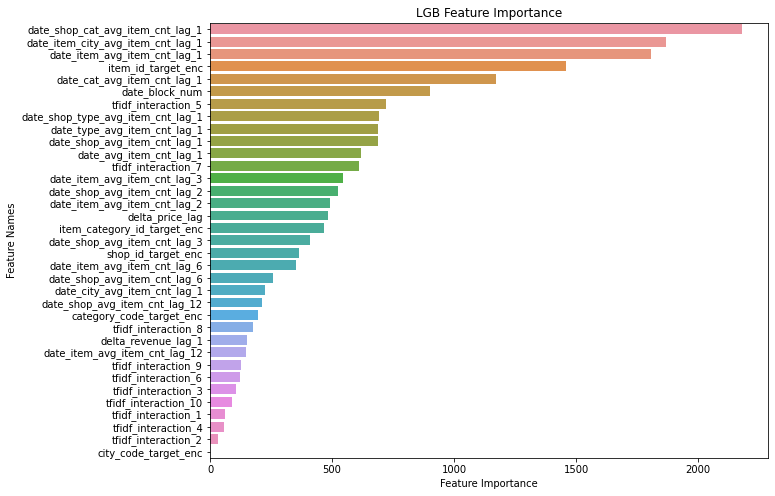

In [168]:
plot_feature_importance(model_lgbm.feature_importance(), X_train.columns, 'LGB')

In [118]:
submission = sample_submission.copy()
submission['item_cnt_month'] = model_lgbm.predict(X_test)
submission.to_csv(submission_path_builder('submission_lgbm.csv'), index=False)

with open(model_path_builder('lgbm.pkl'), 'wb') as file:
    pkl.dump(model_lgbm, file)
    
del submission
gc.collect()

81

### XGBRegressor

In [121]:
model_xgb = xgb.XGBRegressor(max_depth=8, n_estimators=1000, min_child_weight=300,
                             colsample_bytree=0.8, subsample=0.8, eta=0.2, seed=42,
                             reg_alpha=2.0, reg_lambda=2.0)

model_xgb.fit(X_train, Y_train, eval_metric='rmse', eval_set=[(X_valid, Y_valid)],
              verbose=False, early_stopping_rounds=100)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.2, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.200000003, max_delta_step=0, max_depth=8,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=2.0, reg_lambda=2.0, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='approx', validate_parameters=1,
             verbosity=None)

In [122]:
print(np.sqrt(mean_squared_error(Y_valid, model_xgb.predict(X_valid))))

0.9590527


#### Feature importance

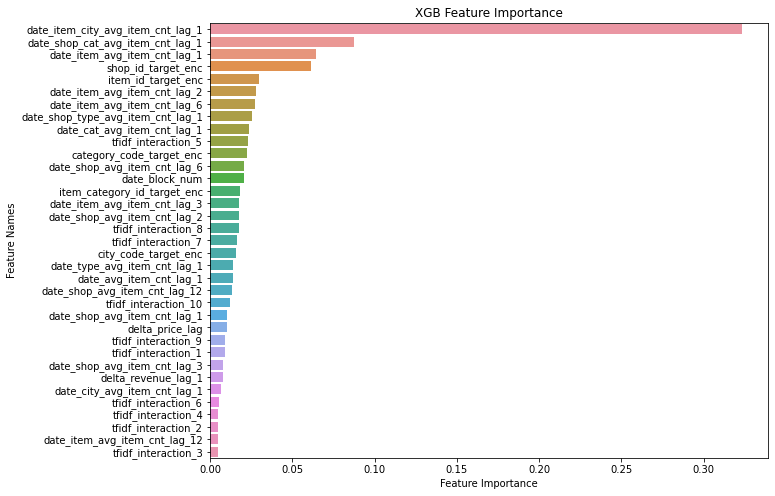

In [175]:
plot_feature_importance(model_xgb.feature_importances_, X_train.columns, 'XGB')

In [123]:
submission = sample_submission.copy()
submission['item_cnt_month'] = model_xgb.predict(X_test)
submission.to_csv(submission_path_builder('submission_xgb.csv'), index=False)

with open(model_path_builder('new_try_xgb.pkl'), 'wb') as file:
    pkl.dump(model_xgb, file)
    
del submission
gc.collect()

153

### CatBoost
Since catboost was well introduced in honor videos we will try it here

In [153]:
catboost_model = CatBoostRegressor(iterations=1000,
                                  max_ctr_complexity=4,
                                  random_seed=42,
                                  od_type='Iter',
                                  od_wait=25,
                                  logging_level='Info',
                                  depth=4
                                  )

catboost_model.fit(X_train, Y_train.astype('int'), cat_features=[], eval_set=(X_valid, Y_valid.astype('int')))

Learning rate set to 0.239925

date_item_city_avg_item_cnt_lag_1, bin=114 score 1278.836301
date_item_city_avg_item_cnt_lag_1, bin=222 score 1442.275321
date_shop_cat_avg_item_cnt_lag_1, bin=201 score 1553.016885
date_item_avg_item_cnt_lag_1, bin=184 score 1631.566306
0:	learn: 1.1092250	test: 1.0825270	best: 1.0825270 (0)	total: 626ms	remaining: 10m 25s

date_item_city_avg_item_cnt_lag_1, bin=137 score 995.8555534
date_item_city_avg_item_cnt_lag_1, bin=40 score 1129.688725
date_item_city_avg_item_cnt_lag_1, bin=249 score 1229.569414
shop_id_target_enc, bin=195 score 1312.219469
1:	learn: 1.0549813	test: 1.0472866	best: 1.0472866 (1)	total: 998ms	remaining: 8m 18s

date_item_city_avg_item_cnt_lag_1, bin=171 score 787.8557571
item_id_target_enc, bin=242 score 925.8259138
date_shop_cat_avg_item_cnt_lag_1, bin=245 score 1014.217642
date_item_city_avg_item_cnt_lag_1, bin=21 score 1074.397793
2:	learn: 1.0171313	test: 1.0267093	best: 1.0267093 (2)	total: 1.44s	remaining: 7m 57s

date_item_c

date_shop_cat_avg_item_cnt_lag_1, bin=249 score 86.72577181
date_item_city_avg_item_cnt_lag_1, bin=118 score 115.4011273
date_shop_cat_avg_item_cnt_lag_1, bin=183 score 157.2149923
27:	learn: 0.8820463	test: 0.9688419	best: 0.9674194 (17)	total: 14.1s	remaining: 8m 10s

item_id_target_enc, bin=69 score 46.08527561
shop_id_target_enc, bin=197 score 75.81404294
date_shop_avg_item_cnt_lag_2, bin=138 score 134.9212147
date_shop_avg_item_cnt_lag_6, bin=91 score 209.6654923
28:	learn: 0.8803474	test: 0.9681020	best: 0.9674194 (17)	total: 14.7s	remaining: 8m 12s

date_item_avg_item_cnt_lag_3, bin=253 score 41.95775567
date_item_avg_item_cnt_lag_2, bin=253 score 89.98229142
category_code_target_enc, bin=41 score 112.5191872
date_cat_avg_item_cnt_lag_1, bin=253 score 144.43721
29:	learn: 0.8795327	test: 0.9677327	best: 0.9674194 (17)	total: 15.2s	remaining: 8m 12s

date_item_avg_item_cnt_lag_1, bin=66 score 39.8025095
date_shop_avg_item_cnt_lag_12, bin=203 score 77.23727393
date_cat_avg_item_cn

54:	learn: 0.8618560	test: 0.9663508	best: 0.9663043 (31)	total: 29.9s	remaining: 8m 33s

date_avg_item_cnt_lag_1, bin=15 score 24.32063074
date_avg_item_cnt_lag_1, bin=17 score 53.52221734
date_item_avg_item_cnt_lag_1, bin=239 score 111.1445946
date_avg_item_cnt_lag_1, bin=13 score 135.7761322
55:	learn: 0.8611267	test: 0.9663329	best: 0.9663043 (31)	total: 30.5s	remaining: 8m 33s

date_shop_cat_avg_item_cnt_lag_1, bin=90 score 22.16753288
date_cat_avg_item_cnt_lag_1, bin=56 score 55.18721815
item_id_target_enc, bin=235 score 77.61431851
item_category_id_target_enc, bin=222 score 132.0796835
56:	learn: 0.8604423	test: 0.9692372	best: 0.9663043 (31)	total: 31.2s	remaining: 8m 35s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.9663042968
bestIteration = 31

Shrink model to first 32 iterations.


In [154]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_valid)
catboost_test_pred = catboost_model.predict(X_test)

In [156]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train.values, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid.values, catboost_val_pred)))

Train rmse: 0.8779046826636521
Validation rmse: 0.9663042967563925


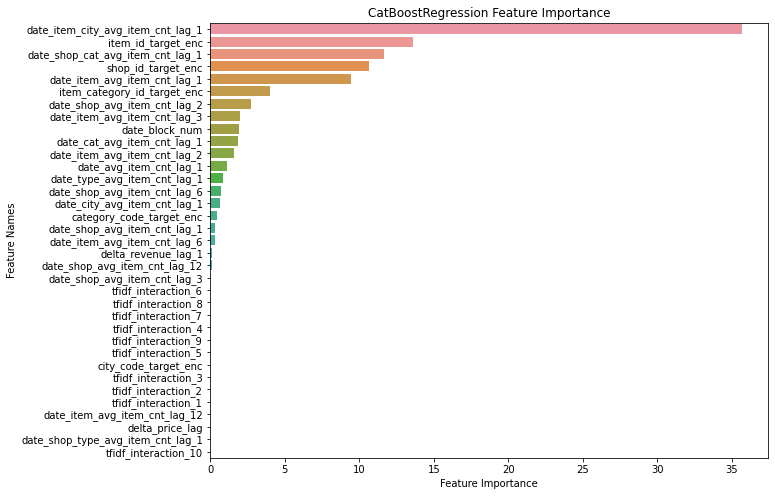

In [179]:
plot_feature_importance(catboost_model.get_feature_importance(), X_train.columns, 'CatBoostRegression')

In [176]:
submission = sample_submission.copy()
submission['item_cnt_month'] = catboost_test_pred
submission.to_csv(submission_path_builder('submission_catboost.csv'), index=False)

with open(model_path_builder('catboost.pkl'), 'wb') as file:
    pkl.dump(catboost_model, file)
    
del submission
gc.collect()

40250

In [177]:
catboost_model_2 = CatBoostRegressor(iterations=1000,
                                  max_ctr_complexity=4,
                                  random_seed=42,
                                  od_type='Iter',
                                  od_wait=25,
                                  logging_level='Info',
                                  depth=6,
                                  learning_rate=0.005
                                  )

catboost_model_2.fit(X_train, Y_train.astype('int'), cat_features=[], eval_set=(X_valid, Y_valid.astype('int')))


date_item_city_avg_item_cnt_lag_1, bin=114 score 1278.836301
date_item_city_avg_item_cnt_lag_1, bin=222 score 1442.275321
date_shop_cat_avg_item_cnt_lag_1, bin=201 score 1553.016885
date_item_avg_item_cnt_lag_1, bin=184 score 1631.566306
shop_id_target_enc, bin=195 score 1684.249938
item_id_target_enc, bin=239 score 1731.959806
0:	learn: 1.1862160	test: 1.1352641	best: 1.1352641 (0)	total: 503ms	remaining: 8m 22s

date_item_city_avg_item_cnt_lag_1, bin=115 score 1267.909672
date_item_city_avg_item_cnt_lag_1, bin=229 score 1433.466768
date_shop_cat_avg_item_cnt_lag_1, bin=205 score 1541.209299
date_item_avg_item_cnt_lag_1, bin=183 score 1620.252282
shop_id_target_enc, bin=197 score 1673.326684
item_id_target_enc, bin=252 score 1723.879441
1:	learn: 1.1841969	test: 1.1338783	best: 1.1338783 (1)	total: 974ms	remaining: 8m 6s

date_item_city_avg_item_cnt_lag_1, bin=114 score 1266.672005
date_item_city_avg_item_cnt_lag_1, bin=224 score 1429.31429
date_shop_cat_avg_item_cnt_lag_1, bin=199 s

19:	learn: 1.1505829	test: 1.1123371	best: 1.1123371 (19)	total: 10.6s	remaining: 8m 37s

date_item_city_avg_item_cnt_lag_1, bin=114 score 1157.030377
date_item_city_avg_item_cnt_lag_1, bin=210 score 1309.948877
date_shop_cat_avg_item_cnt_lag_1, bin=199 score 1409.884335
date_item_avg_item_cnt_lag_1, bin=176 score 1483.571064
shop_id_target_enc, bin=197 score 1530.018189
item_id_target_enc, bin=239 score 1577.80544
20:	learn: 1.1488354	test: 1.1112666	best: 1.1112666 (20)	total: 11.2s	remaining: 8m 42s

date_item_city_avg_item_cnt_lag_1, bin=137 score 1154.851713
date_item_city_avg_item_cnt_lag_1, bin=41 score 1299.572293
date_item_city_avg_item_cnt_lag_1, bin=245 score 1405.712053
shop_id_target_enc, bin=197 score 1475.911177
item_id_target_enc, bin=238 score 1529.863397
date_shop_avg_item_cnt_lag_2, bin=0 score 1578.910065
21:	learn: 1.1470852	test: 1.1102327	best: 1.1102327 (21)	total: 11.9s	remaining: 8m 48s

date_item_city_avg_item_cnt_lag_1, bin=138 score 1146.897812
date_item_ci

date_item_city_avg_item_cnt_lag_1, bin=249 score 1290.123067
date_shop_cat_avg_item_cnt_lag_1, bin=235 score 1359.82701
shop_id_target_enc, bin=196 score 1397.344069
date_item_avg_item_cnt_lag_1, bin=228 score 1441.500615
39:	learn: 1.1182938	test: 1.0923840	best: 1.0923840 (39)	total: 23.3s	remaining: 9m 19s

date_item_city_avg_item_cnt_lag_1, bin=137 score 1051.862784
date_item_city_avg_item_cnt_lag_1, bin=40 score 1184.895015
date_item_city_avg_item_cnt_lag_1, bin=245 score 1285.762725
date_shop_cat_avg_item_cnt_lag_1, bin=195 score 1350.50715
shop_id_target_enc, bin=222 score 1390.34328
item_id_target_enc, bin=224 score 1430.075912
40:	learn: 1.1168195	test: 1.0914462	best: 1.0914462 (40)	total: 23.9s	remaining: 9m 19s

date_item_city_avg_item_cnt_lag_1, bin=114 score 1048.002313
date_item_city_avg_item_cnt_lag_1, bin=214 score 1187.958448
date_shop_cat_avg_item_cnt_lag_1, bin=197 score 1279.672463
date_item_avg_item_cnt_lag_1, bin=202 score 1344.147736
shop_id_target_enc, bin=195 

58:	learn: 1.0917032	test: 1.0757160	best: 1.0757160 (58)	total: 35.3s	remaining: 9m 23s

date_item_city_avg_item_cnt_lag_1, bin=157 score 959.9904282
date_item_city_avg_item_cnt_lag_1, bin=40 score 1110.845431
date_shop_cat_avg_item_cnt_lag_1, bin=240 score 1192.974136
date_item_city_avg_item_cnt_lag_1, bin=249 score 1247.921928
item_id_target_enc, bin=241 score 1288.430851
date_item_avg_item_cnt_lag_2, bin=1 score 1330.807228
59:	learn: 1.0903977	test: 1.0749588	best: 1.0749588 (59)	total: 35.9s	remaining: 9m 22s

date_item_city_avg_item_cnt_lag_1, bin=139 score 955.7184403
date_item_city_avg_item_cnt_lag_1, bin=43 score 1079.278654
date_item_city_avg_item_cnt_lag_1, bin=249 score 1169.821786
shop_id_target_enc, bin=222 score 1233.443363
item_id_target_enc, bin=202 score 1279.760033
date_item_avg_item_cnt_lag_3, bin=0 score 1331.268025
60:	learn: 1.0890937	test: 1.0741963	best: 1.0741963 (60)	total: 36.6s	remaining: 9m 22s

date_item_city_avg_item_cnt_lag_1, bin=156 score 949.0909338

date_item_city_avg_item_cnt_lag_1, bin=45 score 1015.894172
date_shop_cat_avg_item_cnt_lag_1, bin=243 score 1095.572161
date_item_city_avg_item_cnt_lag_1, bin=252 score 1142.920722
shop_id_target_enc, bin=222 score 1182.054368
item_id_target_enc, bin=223 score 1220.851422
78:	learn: 1.0673584	test: 1.0609143	best: 1.0609143 (78)	total: 48.5s	remaining: 9m 25s

date_item_city_avg_item_cnt_lag_1, bin=114 score 876.2751053
date_item_city_avg_item_cnt_lag_1, bin=230 score 995.3908084
date_item_city_avg_item_cnt_lag_1, bin=21 score 1071.494435
date_shop_cat_avg_item_cnt_lag_1, bin=238 score 1134.152577
item_id_target_enc, bin=247 score 1171.782796
shop_id_target_enc, bin=196 score 1209.91388
79:	learn: 1.0662517	test: 1.0602449	best: 1.0602449 (79)	total: 49.2s	remaining: 9m 25s

date_item_city_avg_item_cnt_lag_1, bin=114 score 871.3925008
date_item_city_avg_item_cnt_lag_1, bin=222 score 992.8169235
date_shop_cat_avg_item_cnt_lag_1, bin=193 score 1070.723321
date_item_avg_item_cnt_lag_1, bi

item_category_id_target_enc, bin=237 score 1129.079221
97:	learn: 1.0474074	test: 1.0485373	best: 1.0485373 (97)	total: 1m 1s	remaining: 9m 24s

date_item_city_avg_item_cnt_lag_1, bin=164 score 803.1838538
date_item_city_avg_item_cnt_lag_1, bin=43 score 932.3219476
date_shop_cat_avg_item_cnt_lag_1, bin=253 score 999.9959795
date_shop_type_avg_item_cnt_lag_1, bin=192 score 1050.456347
item_id_target_enc, bin=179 score 1084.068655
shop_id_target_enc, bin=213 score 1119.813698
98:	learn: 1.0464451	test: 1.0478755	best: 1.0478755 (98)	total: 1m 2s	remaining: 9m 24s

date_item_city_avg_item_cnt_lag_1, bin=86 score 794.8934077
date_item_city_avg_item_cnt_lag_1, bin=202 score 934.3258948
date_shop_cat_avg_item_cnt_lag_1, bin=180 score 1001.162058
date_shop_cat_avg_item_cnt_lag_1, bin=253 score 1044.889316
item_id_target_enc, bin=210 score 1082.391645
date_shop_avg_item_cnt_lag_2, bin=0 score 1138.683444
99:	learn: 1.0454458	test: 1.0473400	best: 1.0473400 (99)	total: 1m 2s	remaining: 9m 24s




date_item_city_avg_item_cnt_lag_1, bin=166 score 735.319106
date_item_city_avg_item_cnt_lag_1, bin=46 score 854.1712395
date_shop_cat_avg_item_cnt_lag_1, bin=240 score 921.2120729
date_item_city_avg_item_cnt_lag_1, bin=252 score 963.3307427
shop_id_target_enc, bin=222 score 1000.190083
item_id_target_enc, bin=202 score 1035.001948
117:	learn: 1.0289933	test: 1.0377527	best: 1.0377527 (117)	total: 1m 14s	remaining: 9m 16s

date_item_city_avg_item_cnt_lag_1, bin=171 score 730.5909012
date_item_avg_item_cnt_lag_1, bin=223 score 858.8024528
shop_id_target_enc, bin=196 score 942.7338791
item_category_id_target_enc, bin=253 score 995.9979813
item_id_target_enc, bin=167 score 1038.524345
date_shop_avg_item_cnt_lag_2, bin=0 score 1066.535523
118:	learn: 1.0281075	test: 1.0370841	best: 1.0370841 (118)	total: 1m 15s	remaining: 9m 16s

date_item_city_avg_item_cnt_lag_1, bin=160 score 727.787701
date_item_city_avg_item_cnt_lag_1, bin=41 score 840.9297292
date_shop_cat_avg_item_cnt_lag_1, bin=253 

date_shop_cat_avg_item_cnt_lag_1, bin=228 score 848.5781946
date_item_avg_item_cnt_lag_1, bin=176 score 888.353921
item_id_target_enc, bin=252 score 925.9483879
shop_id_target_enc, bin=194 score 971.3102225
136:	learn: 1.0135758	test: 1.0277744	best: 1.0277744 (136)	total: 1m 27s	remaining: 9m 11s

date_item_city_avg_item_cnt_lag_1, bin=92 score 668.6037997
date_item_city_avg_item_cnt_lag_1, bin=208 score 787.2379917
date_shop_cat_avg_item_cnt_lag_1, bin=243 score 844.4873544
item_id_target_enc, bin=227 score 885.5689754
date_shop_avg_item_cnt_lag_2, bin=0 score 939.7171224
shop_id_target_enc, bin=209 score 994.1138896
137:	learn: 1.0127917	test: 1.0274088	best: 1.0274088 (137)	total: 1m 28s	remaining: 9m 11s

date_item_city_avg_item_cnt_lag_1, bin=114 score 664.602366
date_item_city_avg_item_cnt_lag_1, bin=229 score 765.3088197
date_item_city_avg_item_cnt_lag_1, bin=20 score 829.5167887
date_shop_cat_avg_item_cnt_lag_1, bin=239 score 881.7776783
date_item_avg_item_cnt_lag_3, bin=242 s


date_item_city_avg_item_cnt_lag_1, bin=165 score 612.3180003
date_item_city_avg_item_cnt_lag_1, bin=45 score 714.5000584
date_shop_cat_avg_item_cnt_lag_1, bin=239 score 775.7248059
date_item_city_avg_item_cnt_lag_1, bin=249 score 815.387297
shop_id_target_enc, bin=222 score 851.5268487
item_id_target_enc, bin=165 score 884.9718862
156:	learn: 0.9991351	test: 1.0195938	best: 1.0195938 (156)	total: 1m 40s	remaining: 8m 59s

date_item_city_avg_item_cnt_lag_1, bin=171 score 611.04591
date_item_avg_item_cnt_lag_1, bin=227 score 723.0871479
shop_id_target_enc, bin=196 score 796.3448857
item_category_id_target_enc, bin=253 score 845.4008078
item_id_target_enc, bin=199 score 885.4290364
date_shop_avg_item_cnt_lag_2, bin=0 score 940.6188433
157:	learn: 0.9984217	test: 1.0192619	best: 1.0192619 (157)	total: 1m 41s	remaining: 8m 59s

date_item_city_avg_item_cnt_lag_1, bin=92 score 609.5890754
date_item_city_avg_item_cnt_lag_1, bin=225 score 717.6415047
date_shop_cat_avg_item_cnt_lag_1, bin=180 s

175:	learn: 0.9873389	test: 1.0123325	best: 1.0123325 (175)	total: 1m 53s	remaining: 8m 49s

date_item_city_avg_item_cnt_lag_1, bin=171 score 561.6181044
date_item_avg_item_cnt_lag_1, bin=228 score 664.3556058
shop_id_target_enc, bin=196 score 736.3035314
item_category_id_target_enc, bin=253 score 782.1671445
item_id_target_enc, bin=169 score 821.3256987
date_item_avg_item_cnt_lag_2, bin=0 score 850.4717817
176:	learn: 0.9867504	test: 1.0119004	best: 1.0119004 (176)	total: 1m 53s	remaining: 8m 49s

date_item_city_avg_item_cnt_lag_1, bin=114 score 558.6429024
date_item_city_avg_item_cnt_lag_1, bin=249 score 644.9575294
date_item_city_avg_item_cnt_lag_1, bin=20 score 703.9069689
shop_id_target_enc, bin=222 score 756.3310539
item_id_target_enc, bin=252 score 792.5588111
date_shop_avg_item_cnt_lag_3, bin=1 score 827.6882189
177:	learn: 0.9861936	test: 1.0115514	best: 1.0115514 (177)	total: 1m 54s	remaining: 8m 48s

date_item_city_avg_item_cnt_lag_1, bin=86 score 553.6384661
date_item_city_

item_id_target_enc, bin=200 score 837.7235847
195:	learn: 0.9762549	test: 1.0058940	best: 1.0058940 (195)	total: 2m 6s	remaining: 8m 39s

date_item_city_avg_item_cnt_lag_1, bin=171 score 512.1992959
date_item_avg_item_cnt_lag_1, bin=212 score 610.8288009
shop_id_target_enc, bin=196 score 674.5781691
item_category_id_target_enc, bin=253 score 721.2398789
item_id_target_enc, bin=171 score 755.3296894
date_item_avg_item_cnt_lag_2, bin=0 score 786.4732293
196:	learn: 0.9757461	test: 1.0055089	best: 1.0055089 (196)	total: 2m 7s	remaining: 8m 39s

date_item_city_avg_item_cnt_lag_1, bin=164 score 508.9185868
date_item_city_avg_item_cnt_lag_1, bin=20 score 601.0052347
date_shop_cat_avg_item_cnt_lag_1, bin=233 score 660.8630433
date_item_city_avg_item_cnt_lag_1, bin=252 score 700.0325326
date_item_avg_item_cnt_lag_3, bin=240 score 731.512585
shop_id_target_enc, bin=222 score 761.3959197
197:	learn: 0.9752685	test: 1.0052174	best: 1.0052174 (197)	total: 2m 7s	remaining: 8m 38s

date_item_city_av

date_item_city_avg_item_cnt_lag_1, bin=180 score 472.8937235
date_item_avg_item_cnt_lag_1, bin=211 score 563.500108
shop_id_target_enc, bin=196 score 629.5547804
item_id_target_enc, bin=252 score 671.4595089
date_item_avg_item_cnt_lag_2, bin=0 score 708.1285529
item_id_target_enc, bin=206 score 778.3613842
215:	learn: 0.9666233	test: 1.0003931	best: 1.0003931 (215)	total: 2m 19s	remaining: 8m 27s

date_item_city_avg_item_cnt_lag_1, bin=79 score 464.9075077
date_item_city_avg_item_cnt_lag_1, bin=229 score 557.8282232
date_shop_cat_avg_item_cnt_lag_1, bin=163 score 607.012092
date_item_avg_item_cnt_lag_1, bin=243 score 643.2164257
item_category_id_target_enc, bin=237 score 676.9985983
date_shop_avg_item_cnt_lag_3, bin=0 score 732.0184725
216:	learn: 0.9661794	test: 1.0000019	best: 1.0000019 (216)	total: 2m 20s	remaining: 8m 27s

date_item_city_avg_item_cnt_lag_1, bin=86 score 465.289195
date_item_city_avg_item_cnt_lag_1, bin=229 score 555.863902
shop_id_target_enc, bin=222 score 601.7496

date_item_avg_item_cnt_lag_6, bin=0 score 715.2649236
234:	learn: 0.9583944	test: 0.9954952	best: 0.9954952 (234)	total: 2m 32s	remaining: 8m 17s

date_item_city_avg_item_cnt_lag_1, bin=170 score 428.0869652
date_item_city_avg_item_cnt_lag_1, bin=30 score 510.8895973
date_shop_cat_avg_item_cnt_lag_1, bin=251 score 564.6527665
date_shop_type_avg_item_cnt_lag_1, bin=184 score 602.2522254
date_item_avg_item_cnt_lag_1, bin=239 score 631.8015115
date_type_avg_item_cnt_lag_1, bin=122 score 666.5880735
235:	learn: 0.9580222	test: 0.9952356	best: 0.9952356 (235)	total: 2m 33s	remaining: 8m 17s

date_item_city_avg_item_cnt_lag_1, bin=179 score 431.0688678
date_item_avg_item_cnt_lag_1, bin=211 score 517.8329315
shop_id_target_enc, bin=192 score 577.986431
item_category_id_target_enc, bin=253 score 618.2925504
item_id_target_enc, bin=149 score 648.9050218
date_shop_avg_item_cnt_lag_2, bin=0 score 682.7671917
236:	learn: 0.9576316	test: 0.9949364	best: 0.9949364 (236)	total: 2m 34s	remaining: 8m 1

date_shop_cat_avg_item_cnt_lag_1, bin=216 score 478.8750394
date_item_city_avg_item_cnt_lag_1, bin=249 score 533.9758492
date_item_city_avg_item_cnt_lag_1, bin=15 score 574.2075353
date_cat_avg_item_cnt_lag_1, bin=215 score 610.8522544
item_category_id_target_enc, bin=237 score 650.3943956
254:	learn: 0.9507855	test: 0.9912550	best: 0.9912550 (254)	total: 2m 46s	remaining: 8m 6s

date_item_avg_item_cnt_lag_1, bin=243 score 392.2529052
date_item_city_avg_item_cnt_lag_1, bin=247 score 476.5483722
shop_id_target_enc, bin=195 score 540.1791711
item_id_target_enc, bin=195 score 590.4241463
date_shop_avg_item_cnt_lag_3, bin=0 score 652.412438
date_block_num, bin=11 score 692.0055959
255:	learn: 0.9503796	test: 0.9911403	best: 0.9911403 (255)	total: 2m 47s	remaining: 8m 6s

date_item_city_avg_item_cnt_lag_1, bin=183 score 392.9219781
date_item_avg_item_cnt_lag_1, bin=230 score 480.1602139
shop_id_target_enc, bin=196 score 539.0278999
item_id_target_enc, bin=169 score 579.6867032
date_shop_cat


date_item_city_avg_item_cnt_lag_1, bin=85 score 361.6668164
date_item_city_avg_item_cnt_lag_1, bin=249 score 438.3373457
date_shop_cat_avg_item_cnt_lag_1, bin=173 score 482.0233286
item_category_id_target_enc, bin=238 score 514.8483605
date_shop_avg_item_cnt_lag_3, bin=0 score 565.2358828
item_id_target_enc, bin=225 score 621.9175139
274:	learn: 0.9436751	test: 0.9879610	best: 0.9879610 (274)	total: 3m 1s	remaining: 7m 57s

date_item_avg_item_cnt_lag_1, bin=243 score 363.7276028
date_shop_cat_avg_item_cnt_lag_1, bin=214 score 439.9276825
date_item_city_avg_item_cnt_lag_1, bin=249 score 492.2663212
date_item_city_avg_item_cnt_lag_1, bin=15 score 529.0955866
date_cat_avg_item_cnt_lag_1, bin=215 score 566.8527678
item_category_id_target_enc, bin=223 score 608.1053886
275:	learn: 0.9433597	test: 0.9877393	best: 0.9877393 (275)	total: 3m 1s	remaining: 7m 56s

date_item_city_avg_item_cnt_lag_1, bin=91 score 360.8768135
date_item_city_avg_item_cnt_lag_1, bin=252 score 433.0091927
date_shop_c

date_shop_avg_item_cnt_lag_6, bin=7 score 624.40123
293:	learn: 0.9376365	test: 0.9851866	best: 0.9851866 (293)	total: 3m 14s	remaining: 7m 47s

date_item_avg_item_cnt_lag_1, bin=243 score 334.3757612
date_shop_cat_avg_item_cnt_lag_1, bin=222 score 409.7156422
date_item_city_avg_item_cnt_lag_1, bin=252 score 457.3740238
date_cat_avg_item_cnt_lag_1, bin=215 score 493.3878391
date_item_city_avg_item_cnt_lag_1, bin=15 score 534.9160835
item_category_id_target_enc, bin=223 score 573.6900576
294:	learn: 0.9373560	test: 0.9850022	best: 0.9850022 (294)	total: 3m 15s	remaining: 7m 47s

date_item_avg_item_cnt_lag_1, bin=239 score 333.6517252
shop_id_target_enc, bin=196 score 409.7564959
date_item_city_avg_item_cnt_lag_1, bin=249 score 469.6437872
item_id_target_enc, bin=136 score 511.3964551
date_item_avg_item_cnt_lag_3, bin=1 score 545.3307292
item_id_target_enc, bin=240 score 590.9381581
295:	learn: 0.9370546	test: 0.9849145	best: 0.9849145 (295)	total: 3m 16s	remaining: 7m 47s

date_item_avg

313:	learn: 0.9319134	test: 0.9827980	best: 0.9827980 (313)	total: 3m 29s	remaining: 7m 36s

date_item_avg_item_cnt_lag_1, bin=249 score 308.0936698
date_shop_cat_avg_item_cnt_lag_1, bin=224 score 376.3823173
date_item_city_avg_item_cnt_lag_1, bin=15 score 426.6130987
date_type_avg_item_cnt_lag_1, bin=139 score 469.6005612
item_category_id_target_enc, bin=220 score 511.466506
item_id_target_enc, bin=240 score 568.6623084
314:	learn: 0.9316360	test: 0.9827215	best: 0.9827215 (314)	total: 3m 29s	remaining: 7m 36s

date_item_city_avg_item_cnt_lag_1, bin=86 score 306.9483048
date_shop_cat_avg_item_cnt_lag_1, bin=253 score 371.1648908
item_id_target_enc, bin=242 score 409.7151963
date_shop_avg_item_cnt_lag_2, bin=0 score 472.2949621
shop_id_target_enc, bin=213 score 521.2868648
item_id_target_enc, bin=195 score 566.2910119
315:	learn: 0.9313590	test: 0.9827138	best: 0.9827138 (315)	total: 3m 30s	remaining: 7m 35s

date_item_city_avg_item_cnt_lag_1, bin=189 score 306.2700302
date_item_city_a

333:	learn: 0.9267729	test: 0.9811009	best: 0.9811009 (333)	total: 3m 43s	remaining: 7m 24s

date_item_avg_item_cnt_lag_1, bin=239 score 285.0859094
shop_id_target_enc, bin=180 score 351.7921117
date_item_city_avg_item_cnt_lag_1, bin=253 score 403.8846558
item_id_target_enc, bin=140 score 439.6736055
date_shop_avg_item_cnt_lag_3, bin=0 score 473.4179865
item_id_target_enc, bin=235 score 515.3364109
334:	learn: 0.9265428	test: 0.9810474	best: 0.9810474 (334)	total: 3m 43s	remaining: 7m 24s

date_item_avg_item_cnt_lag_1, bin=239 score 283.82412
date_item_city_avg_item_cnt_lag_1, bin=232 score 351.1255775
shop_id_target_enc, bin=209 score 401.9380314
item_id_target_enc, bin=133 score 441.3872343
date_shop_avg_item_cnt_lag_3, bin=1 score 480.6198845
item_id_target_enc, bin=240 score 527.5578347
335:	learn: 0.9263007	test: 0.9809777	best: 0.9809777 (335)	total: 3m 44s	remaining: 7m 23s

date_item_avg_item_cnt_lag_1, bin=249 score 281.064052
date_shop_cat_avg_item_cnt_lag_1, bin=170 score 34

date_block_num, bin=10 score 498.1747129
353:	learn: 0.9222565	test: 0.9793311	best: 0.9793311 (353)	total: 3m 57s	remaining: 7m 12s

date_item_avg_item_cnt_lag_1, bin=249 score 261.7688276
date_shop_cat_avg_item_cnt_lag_1, bin=153 score 324.1394027
date_item_avg_item_cnt_lag_1, bin=133 score 366.2095139
item_category_id_target_enc, bin=238 score 414.7572334
date_type_avg_item_cnt_lag_1, bin=113 score 461.4215399
date_shop_cat_avg_item_cnt_lag_1, bin=246 score 498.3717696
354:	learn: 0.9220398	test: 0.9791435	best: 0.9791435 (354)	total: 3m 57s	remaining: 7m 12s

date_item_avg_item_cnt_lag_1, bin=243 score 259.8707392
date_shop_cat_avg_item_cnt_lag_1, bin=113 score 323.8818512
date_item_city_avg_item_cnt_lag_1, bin=252 score 368.2270731
item_category_id_target_enc, bin=238 score 404.1844802
date_shop_avg_item_cnt_lag_3, bin=1 score 450.2509065
item_id_target_enc, bin=225 score 498.0938985
355:	learn: 0.9218228	test: 0.9790676	best: 0.9790676 (355)	total: 3m 58s	remaining: 7m 11s

date_

373:	learn: 0.9181699	test: 0.9778112	best: 0.9778112 (373)	total: 4m 11s	remaining: 7m

date_item_city_avg_item_cnt_lag_1, bin=193 score 241.7048151
date_item_city_avg_item_cnt_lag_1, bin=20 score 301.9968068
shop_id_target_enc, bin=227 score 344.8755274
date_item_avg_item_cnt_lag_3, bin=242 score 378.5394666
date_item_avg_item_cnt_lag_1, bin=228 score 401.8114383
shop_id_target_enc, bin=155 score 425.0333189
374:	learn: 0.9180111	test: 0.9777191	best: 0.9777191 (374)	total: 4m 11s	remaining: 6m 59s

date_item_city_avg_item_cnt_lag_1, bin=193 score 241.3906984
date_item_city_avg_item_cnt_lag_1, bin=22 score 299.9639289
shop_id_target_enc, bin=227 score 341.903857
date_item_avg_item_cnt_lag_3, bin=242 score 377.2692616
date_shop_cat_avg_item_cnt_lag_1, bin=117 score 399.5304848
item_category_id_target_enc, bin=220 score 437.7832522
375:	learn: 0.9178435	test: 0.9776168	best: 0.9776168 (375)	total: 4m 12s	remaining: 6m 59s

date_item_avg_item_cnt_lag_1, bin=239 score 240.8454734
shop_id

393:	learn: 0.9144812	test: 0.9767488	best: 0.9766764 (392)	total: 4m 25s	remaining: 6m 47s

date_item_avg_item_cnt_lag_1, bin=239 score 223.5592359
shop_id_target_enc, bin=209 score 283.9542712
date_item_city_avg_item_cnt_lag_1, bin=251 score 330.5392299
item_id_target_enc, bin=122 score 365.333746
date_item_avg_item_cnt_lag_2, bin=0 score 403.3799647
item_id_target_enc, bin=239 score 462.5500549
394:	learn: 0.9142929	test: 0.9767370	best: 0.9766764 (392)	total: 4m 25s	remaining: 6m 47s

date_item_avg_item_cnt_lag_1, bin=250 score 221.944023
date_shop_cat_avg_item_cnt_lag_1, bin=140 score 278.7648634
date_item_avg_item_cnt_lag_1, bin=97 score 318.9292069
item_category_id_target_enc, bin=237 score 370.3507314
date_shop_avg_item_cnt_lag_3, bin=1 score 412.7343759
item_id_target_enc, bin=222 score 470.2330437
395:	learn: 0.9140982	test: 0.9767012	best: 0.9766764 (392)	total: 4m 26s	remaining: 6m 46s

date_item_avg_item_cnt_lag_1, bin=246 score 220.6335507
shop_id_target_enc, bin=196 scor

item_category_id_target_enc, bin=224 score 391.9690984
date_item_avg_item_cnt_lag_6, bin=0 score 448.2885422
413:	learn: 0.9111341	test: 0.9757109	best: 0.9757109 (413)	total: 4m 39s	remaining: 6m 35s

date_item_avg_item_cnt_lag_1, bin=243 score 205.5096119
shop_id_target_enc, bin=209 score 263.1802002
date_item_city_avg_item_cnt_lag_1, bin=252 score 308.1084726
item_id_target_enc, bin=119 score 340.6268652
date_shop_avg_item_cnt_lag_3, bin=0 score 380.7352071
item_id_target_enc, bin=224 score 424.9939598
414:	learn: 0.9109746	test: 0.9756899	best: 0.9756899 (414)	total: 4m 39s	remaining: 6m 34s

date_item_city_avg_item_cnt_lag_1, bin=195 score 205.0938305
date_item_city_avg_item_cnt_lag_1, bin=27 score 257.3722137
shop_id_target_enc, bin=227 score 302.3339133
date_item_avg_item_cnt_lag_6, bin=233 score 331.2035054
date_shop_cat_avg_item_cnt_lag_1, bin=250 score 354.3672144
date_cat_avg_item_cnt_lag_1, bin=212 score 387.0539283
415:	learn: 0.9108422	test: 0.9755751	best: 0.9755751 (415

item_category_id_target_enc, bin=238 score 371.4746518
date_shop_avg_item_cnt_lag_2, bin=1 score 407.7873191
433:	learn: 0.9080868	test: 0.9750150	best: 0.9750150 (433)	total: 4m 54s	remaining: 6m 23s

date_item_city_avg_item_cnt_lag_1, bin=203 score 189.8779425
date_item_city_avg_item_cnt_lag_1, bin=15 score 241.4171404
shop_id_target_enc, bin=222 score 278.5598929
date_item_avg_item_cnt_lag_3, bin=242 score 310.4108117
date_item_avg_item_cnt_lag_1, bin=231 score 335.2049856
tfidf_interaction_5, bin=202 score 361.3291585
434:	learn: 0.9079712	test: 0.9749461	best: 0.9749461 (434)	total: 4m 54s	remaining: 6m 23s

date_item_city_avg_item_cnt_lag_1, bin=204 score 189.041551
date_item_avg_item_cnt_lag_1, bin=228 score 240.1011467
shop_id_target_enc, bin=208 score 283.3287681
date_city_avg_item_cnt_lag_1, bin=240 score 317.0632316
item_id_target_enc, bin=153 score 345.7467535
date_shop_avg_item_cnt_lag_3, bin=4 score 377.8791925
435:	learn: 0.9078454	test: 0.9748707	best: 0.9748707 (435)	t

date_shop_cat_avg_item_cnt_lag_1, bin=251 score 360.5806851
453:	learn: 0.9052913	test: 0.9742307	best: 0.9742307 (453)	total: 5m 9s	remaining: 6m 12s

date_item_avg_item_cnt_lag_1, bin=250 score 177.3260429
shop_id_target_enc, bin=191 score 224.1316818
date_item_avg_item_cnt_lag_1, bin=119 score 269.0018063
item_id_target_enc, bin=252 score 299.2822647
date_block_num, bin=11 score 344.6065451
date_block_num, bin=10 score 382.6517717
454:	learn: 0.9051603	test: 0.9742138	best: 0.9742138 (454)	total: 5m 10s	remaining: 6m 11s

date_item_avg_item_cnt_lag_1, bin=249 score 174.2445298
date_shop_cat_avg_item_cnt_lag_1, bin=229 score 224.3790758
date_cat_avg_item_cnt_lag_1, bin=211 score 271.1782903
item_category_id_target_enc, bin=223 score 312.7252505
item_id_target_enc, bin=234 score 373.0930627
date_shop_avg_item_cnt_lag_6, bin=4 score 440.2322408
455:	learn: 0.9049888	test: 0.9742700	best: 0.9742138 (454)	total: 5m 11s	remaining: 6m 11s

date_item_city_avg_item_cnt_lag_1, bin=203 score 1

473:	learn: 0.9027163	test: 0.9739838	best: 0.9739119 (466)	total: 5m 24s	remaining: 6m

date_item_city_avg_item_cnt_lag_1, bin=230 score 162.6531167
date_item_city_avg_item_cnt_lag_1, bin=16 score 211.0417395
shop_id_target_enc, bin=227 score 247.2919845
date_item_avg_item_cnt_lag_1, bin=231 score 278.2053395
date_item_avg_item_cnt_lag_3, bin=241 score 302.3776865
date_block_num, bin=11 score 327.7806083
474:	learn: 0.9026212	test: 0.9739413	best: 0.9739119 (466)	total: 5m 25s	remaining: 5m 59s

date_item_avg_item_cnt_lag_1, bin=250 score 162.5851933
date_shop_cat_avg_item_cnt_lag_1, bin=252 score 209.8631258
shop_id_target_enc, bin=155 score 251.7385716
date_item_avg_item_cnt_lag_3, bin=234 score 290.7766518
date_cat_avg_item_cnt_lag_1, bin=216 score 317.2974577
item_id_target_enc, bin=142 score 356.2458959
475:	learn: 0.9025085	test: 0.9738749	best: 0.9738749 (475)	total: 5m 26s	remaining: 5m 59s

date_item_city_avg_item_cnt_lag_1, bin=70 score 161.2190129
date_shop_cat_avg_item_cnt


date_item_avg_item_cnt_lag_1, bin=250 score 149.6812268
date_shop_cat_avg_item_cnt_lag_1, bin=116 score 196.2620553
item_category_id_target_enc, bin=224 score 230.0201527
date_shop_avg_item_cnt_lag_3, bin=0 score 287.3123324
item_id_target_enc, bin=206 score 354.5559684
shop_id_target_enc, bin=213 score 421.1876281
494:	learn: 0.9002695	test: 0.9731728	best: 0.9731370 (493)	total: 5m 42s	remaining: 5m 49s

date_item_city_avg_item_cnt_lag_1, bin=69 score 147.8508983
date_shop_cat_avg_item_cnt_lag_1, bin=253 score 199.322156
date_avg_item_cnt_lag_1, bin=17 score 233.6012912
date_avg_item_cnt_lag_1, bin=16 score 270.4128496
item_id_target_enc, bin=240 score 313.8096645
date_item_avg_item_cnt_lag_2, bin=0 score 371.0887525
495:	learn: 0.9001478	test: 0.9732232	best: 0.9731370 (493)	total: 5m 42s	remaining: 5m 48s

date_item_city_avg_item_cnt_lag_1, bin=240 score 148.1662971
date_item_avg_item_cnt_lag_1, bin=228 score 197.0397454
shop_id_target_enc, bin=209 score 237.7395912
tfidf_interact

date_item_city_avg_item_cnt_lag_1, bin=245 score 140.2033875
date_item_avg_item_cnt_lag_1, bin=230 score 184.6590252
shop_id_target_enc, bin=213 score 227.2290316
date_city_avg_item_cnt_lag_1, bin=240 score 260.3011014
item_id_target_enc, bin=149 score 287.8501556
date_item_avg_item_cnt_lag_2, bin=0 score 327.0096409
514:	learn: 0.8980654	test: 0.9727040	best: 0.9727040 (514)	total: 5m 58s	remaining: 5m 37s

date_item_avg_item_cnt_lag_1, bin=250 score 138.5700125
shop_id_target_enc, bin=190 score 183.5928925
date_item_avg_item_cnt_lag_1, bin=120 score 221.8835369
date_shop_cat_avg_item_cnt_lag_1, bin=45 score 251.1015509
item_id_target_enc, bin=202 score 300.5562355
date_shop_avg_item_cnt_lag_6, bin=0 score 376.0228985
515:	learn: 0.8979392	test: 0.9728078	best: 0.9727040 (514)	total: 5m 59s	remaining: 5m 36s

date_item_city_avg_item_cnt_lag_1, bin=230 score 139.9583002
date_item_avg_item_cnt_lag_1, bin=233 score 182.9540656
shop_id_target_enc, bin=157 score 222.4483087
date_city_avg_i


date_item_avg_item_cnt_lag_1, bin=250 score 130.3064045
date_shop_cat_avg_item_cnt_lag_1, bin=100 score 171.7705108
item_category_id_target_enc, bin=238 score 206.2767749
date_shop_avg_item_cnt_lag_3, bin=3 score 258.7865874
category_code_target_enc, bin=46 score 301.9231056
item_id_target_enc, bin=251 score 362.6599774
534:	learn: 0.8960081	test: 0.9724198	best: 0.9724198 (534)	total: 6m 14s	remaining: 5m 25s

date_item_city_avg_item_cnt_lag_1, bin=241 score 128.4915256
date_item_city_avg_item_cnt_lag_1, bin=11 score 170.8144721
date_shop_cat_avg_item_cnt_lag_1, bin=233 score 207.2473463
date_cat_avg_item_cnt_lag_1, bin=215 score 242.3189118
date_item_avg_item_cnt_lag_3, bin=240 score 277.2614095
item_category_id_target_enc, bin=224 score 309.2252133
535:	learn: 0.8959228	test: 0.9723688	best: 0.9723688 (535)	total: 6m 14s	remaining: 5m 24s

date_item_avg_item_cnt_lag_1, bin=236 score 127.2771172
date_shop_cat_avg_item_cnt_lag_1, bin=106 score 177.5055975
item_category_id_target_enc,

date_shop_cat_avg_item_cnt_lag_1, bin=252 score 121.6821449
date_item_city_avg_item_cnt_lag_1, bin=35 score 168.0764424
date_type_avg_item_cnt_lag_1, bin=156 score 201.3413257
shop_id_target_enc, bin=227 score 238.1993494
item_id_target_enc, bin=117 score 265.1914293
date_shop_avg_item_cnt_lag_2, bin=0 score 299.0714302
554:	learn: 0.8940556	test: 0.9719586	best: 0.9719586 (554)	total: 6m 28s	remaining: 5m 11s

date_item_city_avg_item_cnt_lag_1, bin=229 score 121.2544924
item_id_target_enc, bin=249 score 161.3912849
date_block_num, bin=11 score 219.6406611
date_shop_avg_item_cnt_lag_2, bin=0 score 252.1303538
item_id_target_enc, bin=217 score 320.7291883
shop_id_target_enc, bin=198 score 386.1400694
555:	learn: 0.8939214	test: 0.9719555	best: 0.9719555 (555)	total: 6m 29s	remaining: 5m 11s

date_item_city_avg_item_cnt_lag_1, bin=252 score 120.6543433
date_item_city_avg_item_cnt_lag_1, bin=14 score 161.5938209
date_shop_type_avg_item_cnt_lag_1, bin=239 score 194.1739886
date_city_avg_it

date_shop_cat_avg_item_cnt_lag_1, bin=253 score 114.8726035
item_id_target_enc, bin=253 score 155.8356383
date_cat_avg_item_cnt_lag_1, bin=204 score 189.325622
item_category_id_target_enc, bin=238 score 226.0522983
date_block_num, bin=11 score 287.3427001
item_id_target_enc, bin=197 score 339.1749712
574:	learn: 0.8921934	test: 0.9714578	best: 0.9714578 (574)	total: 6m 42s	remaining: 4m 57s

date_item_avg_item_cnt_lag_1, bin=249 score 114.1502524
date_shop_cat_avg_item_cnt_lag_1, bin=114 score 153.3699721
date_item_avg_item_cnt_lag_1, bin=55 score 186.3485575
item_category_id_target_enc, bin=238 score 236.9609432
date_shop_avg_item_cnt_lag_3, bin=3 score 277.1357495
item_id_target_enc, bin=207 score 333.1719348
575:	learn: 0.8920926	test: 0.9714946	best: 0.9714578 (574)	total: 6m 43s	remaining: 4m 56s

date_item_city_avg_item_cnt_lag_1, bin=252 score 112.7471412
date_item_city_avg_item_cnt_lag_1, bin=10 score 151.8911681
date_shop_cat_avg_item_cnt_lag_1, bin=228 score 182.5941133
date_

593:	learn: 0.8905582	test: 0.9707835	best: 0.9707835 (593)	total: 6m 55s	remaining: 4m 44s

item_id_target_enc, bin=253 score 108.4242553
date_block_num, bin=11 score 157.050242
item_id_target_enc, bin=240 score 206.0366141
date_shop_avg_item_cnt_lag_2, bin=0 score 267.918136
shop_id_target_enc, bin=197 score 314.0858535
item_id_target_enc, bin=195 score 377.037345
594:	learn: 0.8904307	test: 0.9707810	best: 0.9707810 (594)	total: 6m 56s	remaining: 4m 43s

date_item_avg_item_cnt_lag_1, bin=250 score 107.0362766
date_shop_cat_avg_item_cnt_lag_1, bin=98 score 146.1525383
date_item_avg_item_cnt_lag_1, bin=59 score 180.2071565
item_id_target_enc, bin=251 score 231.8743007
date_shop_avg_item_cnt_lag_2, bin=0 score 277.1603664
item_category_id_target_enc, bin=224 score 324.6334582
595:	learn: 0.8903352	test: 0.9708533	best: 0.9707810 (594)	total: 6m 57s	remaining: 4m 42s

item_id_target_enc, bin=253 score 106.1948213
date_block_num, bin=11 score 155.9560894
item_id_target_enc, bin=218 score


date_shop_cat_avg_item_cnt_lag_1, bin=252 score 100.2731593
item_id_target_enc, bin=253 score 138.7554523
date_cat_avg_item_cnt_lag_1, bin=212 score 180.996687
item_id_target_enc, bin=106 score 213.4587754
date_block_num, bin=11 score 250.1887631
item_category_id_target_enc, bin=236 score 307.9551142
614:	learn: 0.8886565	test: 0.9705578	best: 0.9705341 (612)	total: 7m 10s	remaining: 4m 29s

date_item_city_avg_item_cnt_lag_1, bin=245 score 100.3391955
item_id_target_enc, bin=249 score 134.0275197
date_block_num, bin=11 score 190.1698466
date_item_avg_item_cnt_lag_2, bin=0 score 222.893538
item_id_target_enc, bin=217 score 285.9123947
shop_id_target_enc, bin=199 score 352.4197814
615:	learn: 0.8885440	test: 0.9705546	best: 0.9705341 (612)	total: 7m 11s	remaining: 4m 28s

date_item_city_avg_item_cnt_lag_1, bin=252 score 100.4940381
date_item_city_avg_item_cnt_lag_1, bin=14 score 132.8439527
shop_id_target_enc, bin=227 score 165.1871866
date_item_avg_item_cnt_lag_1, bin=244 score 188.256

item_category_id_target_enc, bin=238 score 303.7131952
date_item_avg_item_cnt_lag_6, bin=0 score 351.4391197
634:	learn: 0.8870045	test: 0.9701708	best: 0.9701218 (632)	total: 7m 23s	remaining: 4m 15s

date_item_city_avg_item_cnt_lag_1, bin=249 score 95.36128734
date_item_city_avg_item_cnt_lag_1, bin=9 score 125.8450119
shop_id_target_enc, bin=227 score 155.5867315
date_item_avg_item_cnt_lag_3, bin=240 score 178.5418416
date_item_avg_item_cnt_lag_1, bin=244 score 202.387112
tfidf_interaction_5, bin=205 score 226.1444856
635:	learn: 0.8869580	test: 0.9701439	best: 0.9701218 (632)	total: 7m 24s	remaining: 4m 14s

item_id_target_enc, bin=253 score 93.90751103
date_block_num, bin=11 score 140.6161072
item_id_target_enc, bin=240 score 187.3598623
date_shop_avg_item_cnt_lag_1, bin=0 score 243.3809354
item_category_id_target_enc, bin=238 score 301.6711487
date_shop_avg_item_cnt_lag_6, bin=0 score 349.9646766
636:	learn: 0.8868475	test: 0.9702179	best: 0.9701218 (632)	total: 7m 25s	remaining: 


item_id_target_enc, bin=253 score 88.97352819
date_block_num, bin=11 score 133.1085887
item_id_target_enc, bin=240 score 176.7027086
date_item_avg_item_cnt_lag_1, bin=0 score 234.106604
item_category_id_target_enc, bin=236 score 288.7320338
date_shop_avg_item_cnt_lag_6, bin=3 score 335.4035244
655:	learn: 0.8851633	test: 0.9699136	best: 0.9698185 (650)	total: 7m 38s	remaining: 4m

date_item_city_avg_item_cnt_lag_1, bin=252 score 88.94770935
item_id_target_enc, bin=128 score 119.9277693
shop_id_target_enc, bin=227 score 152.2335369
date_item_avg_item_cnt_lag_2, bin=0 score 183.9142888
date_shop_avg_item_cnt_lag_6, bin=4 score 231.8456107
item_category_id_target_enc, bin=215 score 285.8268262
656:	learn: 0.8850877	test: 0.9699004	best: 0.9698185 (650)	total: 7m 39s	remaining: 3m 59s

date_item_avg_item_cnt_lag_1, bin=252 score 88.38763013
date_item_avg_item_cnt_lag_3, bin=249 score 130.7265008
shop_id_target_enc, bin=155 score 160.4241842
date_shop_cat_avg_item_cnt_lag_1, bin=251 score 

date_shop_cat_avg_item_cnt_lag_1, bin=251 score 83.90320548
date_cat_avg_item_cnt_lag_1, bin=201 score 125.6417299
date_item_avg_item_cnt_lag_1, bin=203 score 177.0710279
date_shop_cat_avg_item_cnt_lag_1, bin=192 score 216.8454205
date_avg_item_cnt_lag_1, bin=17 score 242.6612806
date_avg_item_cnt_lag_1, bin=16 score 279.781209
675:	learn: 0.8836438	test: 0.9697719	best: 0.9697528 (672)	total: 7m 52s	remaining: 3m 46s

date_shop_cat_avg_item_cnt_lag_1, bin=251 score 84.35432791
date_cat_avg_item_cnt_lag_1, bin=195 score 126.4468238
date_item_avg_item_cnt_lag_1, bin=176 score 179.970099
date_shop_cat_avg_item_cnt_lag_1, bin=192 score 217.3454231
date_item_avg_item_cnt_lag_1, bin=250 score 242.1815575
item_category_id_target_enc, bin=236 score 269.2204046
676:	learn: 0.8835785	test: 0.9697124	best: 0.9697124 (676)	total: 7m 52s	remaining: 3m 45s

item_id_target_enc, bin=253 score 83.31230977
date_block_num, bin=11 score 126.8202213
item_id_target_enc, bin=217 score 168.6038451
date_cat_a

shop_id_target_enc, bin=31 score 267.9594553
item_category_id_target_enc, bin=222 score 310.2130265
695:	learn: 0.8820988	test: 0.9699409	best: 0.9697124 (676)	total: 8m 6s	remaining: 3m 32s

date_shop_cat_avg_item_cnt_lag_1, bin=251 score 79.56152091
date_cat_avg_item_cnt_lag_1, bin=198 score 123.554771
date_item_avg_item_cnt_lag_1, bin=164 score 170.8187607
date_shop_cat_avg_item_cnt_lag_1, bin=192 score 207.4414933
date_item_avg_item_cnt_lag_1, bin=249 score 236.0650374
date_city_avg_item_cnt_lag_1, bin=240 score 260.8884157
696:	learn: 0.8820370	test: 0.9698805	best: 0.9697124 (676)	total: 8m 6s	remaining: 3m 31s

date_item_city_avg_item_cnt_lag_1, bin=252 score 81.08307889
item_id_target_enc, bin=94 score 109.1767024
shop_id_target_enc, bin=213 score 140.4178864
date_shop_avg_item_cnt_lag_2, bin=0 score 188.3609485
date_item_avg_item_cnt_lag_6, bin=0 score 242.9567193
item_id_target_enc, bin=195 score 299.9151271
697:	learn: 0.8819548	test: 0.9698804	best: 0.9697124 (676)	total: 8

In [178]:
catboost_train_pred_2 = catboost_model_2.predict(X_train)
catboost_val_pred_2 = catboost_model_2.predict(X_valid)
catboost_test_pred_2 = catboost_model_2.predict(X_test)

In [180]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train.values, catboost_train_pred_2)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid.values, catboost_val_pred_2)))

Train rmse: 0.8835784842127921
Validation rmse: 0.969712440208146


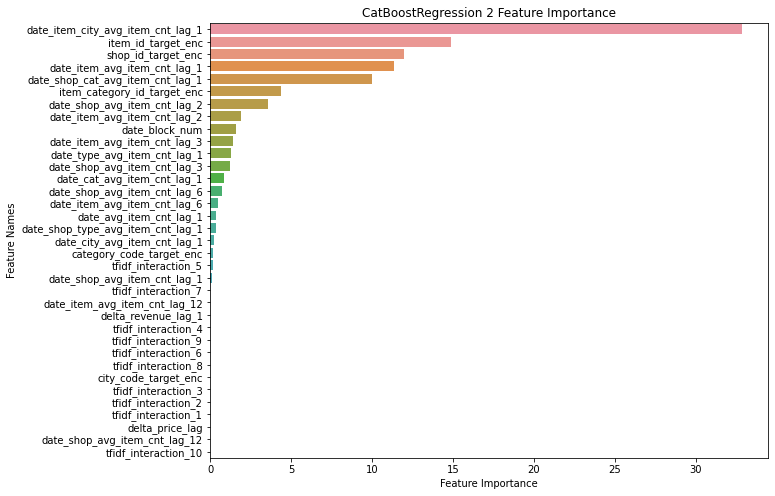

In [181]:
plot_feature_importance(catboost_model_2.get_feature_importance(), X_train.columns, 'CatBoostRegression 2')

In [182]:
submission = sample_submission.copy()
submission['item_cnt_month'] = catboost_test_pred_2
submission.to_csv(submission_path_builder('submission_catboost_2.csv'), index=False)

with open(model_path_builder('catboost_2.pkl'), 'wb') as file:
    pkl.dump(catboost_model_2, file)
    
del submission
gc.collect()

20307

### Linear Models

In [183]:
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_valid_std = scaler.transform(X_valid)

In [185]:
model_linreg = LinearRegression(fit_intercept=True)
model_linreg.fit(X_train_std, Y_train)
print(np.sqrt(mean_squared_error(Y_valid, model_linreg.predict(X_valid_std))))
submission = sample_submission.copy()
submission['item_cnt_month'] = model_linreg.predict(scaler.transform(X_test))
submission.to_csv(submission_path_builder('submission_linreg.csv'), index=False)

with open(model_path_builder('linreg.pkl'), 'wb') as file:
    pkl.dump(model_linreg, file)
    
del submission
gc.collect()

0.98995199243231


15

In [186]:
model_ridge = Ridge(alpha=4.0, fit_intercept=True, max_iter=1000, solver='saga')
model_ridge.fit(X_train_std, Y_train)
print(np.sqrt(mean_squared_error(Y_valid, model_ridge.predict(X_valid_std))))
submission = sample_submission.copy()
submission['item_cnt_month'] = model_ridge.predict(scaler.transform(X_test))
submission.to_csv(submission_path_builder('submission_ridge.csv'), index=False)

with open(model_path_builder('ridge.pkl'), 'wb') as file:
    pkl.dump(model_ridge, file)
    
del submission
gc.collect()

0.9899303495672213


15

In [187]:
model_lasso = Lasso(alpha=10.0, fit_intercept=True, max_iter=1000)
model_lasso.fit(X_train_std, Y_train)
print(np.sqrt(mean_squared_error(Y_valid, model_lasso.predict(X_valid_std))))
submission = sample_submission.copy()
submission['item_cnt_month'] = model_lasso.predict(scaler.transform(X_test))
submission.to_csv(submission_path_builder('submission_lasso.csv'), index=False)

with open(model_path_builder('lasso.pkl'), 'wb') as file:
    pkl.dump(model_lasso, file)
    
del submission
gc.collect()

1.1365583856968577


15

## Second Level Modeling
Create dataset for ensembling learning

In [195]:
# take val pred 2 catboost because of better score on public leaderboard
first_level_val = pd.DataFrame(catboost_val_pred_2, columns=['catboost'])
first_level_val['lgbm'] = model_lgbm.predict(X_valid)
first_level_val['xgb'] = model_xgb.predict(X_valid)
first_level_val['linear_regression'] = model_linreg.predict(X_valid)
first_level_val['ridge'] = model_ridge.predict(X_valid)
first_level_val['label'] = Y_valid.values
first_level_val.head(5)

,catboost,lgbm,xgb,linear_regression,ridge,label
0,0.11,0.02,0.06,-0.63,-0.63,0.00
1,0.09,0.09,0.12,-0.61,-0.61,1.00
2,0.16,0.14,0.14,-0.50,-0.50,0.00
3,0.25,0.22,0.23,-0.16,-0.16,0.00
4,0.05,0.03,0.03,-0.64,-0.64,0.00


Create test dataset for ensemble learning

In [196]:
first_level_test = pd.DataFrame(catboost_test_pred_2, columns=['catboost'])
first_level_test['lgbm'] = model_lgbm.predict(X_test)
first_level_test['xgb'] = model_xgb.predict(X_test)
first_level_test['linear_regression'] = model_linreg.predict(X_test)
first_level_test['ridge'] = model_ridge.predict(X_test)
first_level_test.head()

,catboost,lgbm,xgb,linear_regression,ridge
0,0.51,0.88,0.40,-0.10,-0.10
1,0.16,0.17,0.16,-0.61,-0.61
2,0.70,1.09,0.78,0.21,0.21
3,0.28,0.70,0.29,-0.43,-0.43
4,1.47,3.34,2.80,-0.48,-0.48


Level 2 linear model

In [205]:
scaler = StandardScaler().fit(first_level_val.drop(columns=['label']))
first_level_val_scaled = scaler.transform(first_level_val.drop(columns=['label']))
first_level_test_scaled = scaler.transform(first_level_test)

lr_ensemble = LinearRegression(n_jobs=-1)
lr_ensemble.fit(first_level_val_scaled, first_level_val['label'])

lr_ensemble_pred_test = lr_ensemble.predict(first_level_test_scaled)
lr_ensemble_pred = lr_ensemble.predict(first_level_val_scaled)
print('Train rmse:', np.sqrt(mean_squared_error(first_level_val['label'].values, lr_ensemble_pred)))

submission = sample_submission.copy()
submission['item_cnt_month'] = lr_ensemble_pred_test.clip(0, 20).round()
submission.to_csv(submission_path_builder('submission_lr_ensemble.csv'), index=False)

with open(model_path_builder('lr_ensemble.pkl'), 'wb') as file:
    pkl.dump(lr_ensemble, file)
    
del submission
gc.collect()

Train rmse: 0.9419414415328773


47

Level 2 random forest

In [203]:
model_rfr = RandomForestRegressor(n_estimators=100, criterion='mse', n_jobs=-1, verbose=10)
model_rfr.fit(first_level_val.drop(columns=['label']), first_level_val['label'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100building tree 8 of 100

building tree 9 of 100
building tree 10 of 100
building tree 11 of 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s


building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.9s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100building tree 20 of 100

building tree 21 of 100
building tree 22 of 100
building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.7s


building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.3s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.0s


building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   18.9s


building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   22.8s


building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   29.4s



building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   37.2s


building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   41.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   44.4s finished


RandomForestRegressor(n_jobs=-1, verbose=10)

In [206]:
rfr_ensemble_pred_test = model_rfr.predict(first_level_test.values)
rfr_ensemble_pred = model_rfr.predict(first_level_val.drop(columns=['label']))
print('Train rmse:', np.sqrt(mean_squared_error(first_level_val['label'].values, rfr_ensemble_pred)))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)

Train rmse: 0.5252625202466674


[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished


In [207]:
submission = sample_submission.copy()
submission['item_cnt_month'] = rfr_ensemble_pred_test.clip(0, 20).round()
submission.to_csv(submission_path_builder('submission_rfr_ensemble.csv'), index=False)

with open(model_path_builder('rfr_ensemble.pkl'), 'wb') as file:
    pkl.dump(model_rfr, file)
    
del submission
gc.collect()

48

Level 2 Take mean of all predictions

In [208]:
submission = sample_submission.copy()
submission['item_cnt_month'] = first_level_val.drop(columns=['label']).mean(axis=1).clip(0, 20)
submission.to_csv(submission_path_builder('submission_avg_ensemble.csv'), index=False)

Level 2 Linear Regression of only beste first level model

In [220]:
X_val_mean = first_level_val['lgbm'].mean()
X_val_std = first_level_val['lgbm'].std()
X_val = (first_level_val['lgbm'] - X_val_mean) / X_val_std
Y_val = first_level_val['label']
X_test = (first_level_test['lgbm'] - X_val_mean) / X_val_std
model_linreg_single_feature = LinearRegression(n_jobs=-1)
model_linreg_single_feature.fit(X_val.values.reshape(-1, 1), Y_val)
print('Train rmse:', np.sqrt(mean_squared_error(first_level_val['label'].values, model_linreg_single_feature.predict(X_val.values.reshape(-1, 1)))))
test_pred = model_linreg_single_feature.predict(X_test.values.reshape(-1, 1))

submission = sample_submission.copy()
submission['item_cnt_month'] = test_pred.clip(0, 20).round()
submission.to_csv(submission_path_builder('submission_lr_ensemble_single_feature.csv'), index=False)

with open(model_path_builder('lr_ensemble_single_feature.pkl'), 'wb') as file:
    pkl.dump(model_linreg_single_feature, file)
    
del submission
gc.collect()

Train rmse: 0.947487264614097


190